In [60]:
import openpyxl as op
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

적산전력 시트: 20180101-20211231 빠진 날짜 없음

In [ ]:
df=pd.read_excel('../가공-도장-조립 취합_전체.xlsx').drop(['Unnamed: 0'], axis=1).transpose()

print(df)

gagong_weight = df.values.tolist()[1][:1660]
gagong_length = df.values.tolist()[2][:1660]
dojang_pyomeyun = df.values.tolist()[3][:1660]
dojang_dojang = df.values.tolist()[4][:1660]
jorip_weight = df.values.tolist()[5][:1660]
jorip_length = df.values.tolist()[6][:1660]
jorip_yongchack = df.values.tolist()[7][:1660]
elec_use = df.values.tolist()[8][:1660]
elec_peak = df.values.tolist()[9][:1660]

print(elec_use)
print(elec_peak)
#a.plot(figsize=(20,10)).legend(bbox_to_anchor=(1.0, 1.0),fontsize='large')

In [62]:
print(len(elec_peak))
for i in range(1660):
    if elec_peak[i] == 0:
        mean = 0
        for j in range(i-10, i+11):
            mean += elec_peak[j]
        mean = mean / 20
        elec_peak[i] = mean

print(len(elec_use))
for i in range(1660):
    if elec_use[i] == 0:
        mean = 0
        for j in range(i-10, i+11):
            mean += elec_use[j]
        mean = mean / 20
        elec_use[i] = mean

1660
1660


첫번째 시트, 빠진 날짜 다소 존재

<h1>전처리 마친 정리 시트</h1>

In [63]:
weekly_gagong_weight = []
weekly_gagong_length = []
weekly_dojang_pyomeyun = []
weekly_dojang_dojang = []
weekly_jorip_weight = []
weekly_jorip_length = []
weekly_jorip_yongchack = []
weekly_elec_use = []
weekly_elec_peak = []


for i in range(0, 1660, 5):
    gagong_weight_sum = 0
    gagong_length_sum = 0
    dojang_pyomeyun_sum = 0
    dojang_dojang_sum = 0
    jorip_weight_sum = 0
    jorip_length_sum = 0
    jorip_yongchack_sum = 0
    elec_use_sum = 0
    elec_peak_max = 0
    
    for j in range(5):
        gagong_weight_sum += gagong_weight[i+j]
        gagong_length_sum += gagong_length[i+j]
        dojang_pyomeyun_sum += dojang_pyomeyun[i+j]
        dojang_dojang_sum += dojang_dojang[i+j]
        jorip_weight_sum += jorip_weight[i+j]
        jorip_length_sum += jorip_length[i+j]
        jorip_yongchack_sum += jorip_yongchack[i+j]
        elec_use_sum += elec_use[i+j]
        elec_peak_max = max(elec_peak_max, elec_peak[i+j])
        
    weekly_gagong_weight.append(gagong_weight_sum)
    weekly_gagong_length.append(gagong_length_sum)
    weekly_dojang_pyomeyun.append(dojang_pyomeyun_sum)
    weekly_dojang_dojang.append(dojang_dojang_sum)
    weekly_jorip_weight.append(jorip_weight_sum)
    weekly_jorip_length.append(jorip_length_sum)
    weekly_jorip_yongchack.append(jorip_yongchack_sum)
    weekly_elec_use.append(elec_use_sum)
    weekly_elec_peak.append(elec_peak_max)

PEAK vs 시운전호선 - PEAK

In [ ]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import numpy as np
from sklearn.model_selection import train_test_split

#x=features, y=peak
X_train = []
X_train.append(np.array(weekly_gagong_weight, dtype=object))
X_train.append(np.array(weekly_gagong_length, dtype=object))
X_train.append(np.array(weekly_dojang_pyomeyun, dtype=object))
X_train.append(np.array(weekly_dojang_dojang, dtype=object))
X_train.append(np.array(weekly_jorip_weight, dtype=object))
X_train.append(np.array(weekly_jorip_length, dtype=object))
X_train.append(np.array(weekly_jorip_yongchack, dtype=object))
X_train=np.array(X_train).transpose()

y_train = np.array(weekly_elec_peak, dtype=object)
xtrain, xtest, ytrain, ytest=te=train_test_split(X_train, y_train, test_size=0.2)
xgb_model = xgboost.XGBRegressor(base_score=0.5, booster="gbtree", colsample_bylevel=1, colsample_bynode=1, 
                                 colsample_bytree=1, gpu_id=-1, importance_type="gain", interaction_constraints='', learning_rate=0.1, 
                                 max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints='()', n_estimators=100, 
                                 gamma=0, n_jobs=0, num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                 subsample=1, tree_method="exact", validate_parameter=1, verbosity=None)

print(X_train.shape)
xgb_model.fit(X_train,y_train)
ypred=xgb_model.predict(xtest)
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original", alpha=1)
plt.plot(x_ax, ypred, label="predicted", alpha=1)
plt.title("USE")
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

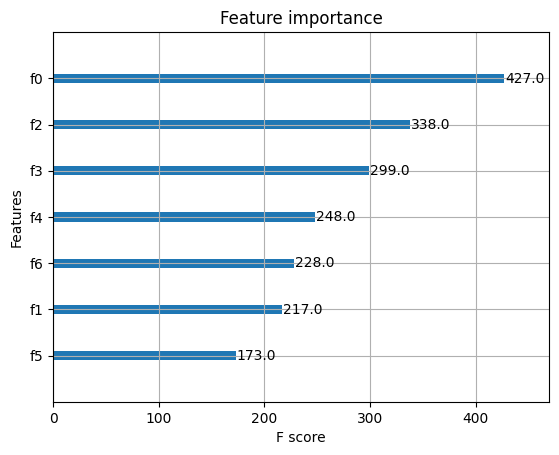

In [65]:
xgboost.plot_importance(xgb_model)
#부하율, 온도, 습도, 최고기온, 최고습도, 조립량, 조립량 전체
#  0     1      2     3        4        5       6

In [66]:
r_sq = xgb_model.score(X_train, y_train)
print(r_sq)

# xgb_model.save_model("Peak_daily_model.txt")

0.9872067190319804


PEAK vs 시운전호선 - 총전력

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import numpy as np

#x=features, y=peak
X_train_ = []
X_train_.append(np.array(weekly_gagong_weight, dtype=object))
X_train_.append(np.array(weekly_gagong_length, dtype=object))
X_train_.append(np.array(weekly_dojang_pyomeyun, dtype=object))
X_train_.append(np.array(weekly_dojang_dojang, dtype=object))
X_train_.append(np.array(weekly_jorip_weight, dtype=object))
X_train_.append(np.array(weekly_jorip_length, dtype=object))
X_train_.append(np.array(weekly_jorip_yongchack, dtype=object))
X_train_=np.array(X_train_).transpose()

y_train_ = np.array(weekly_elec_use, dtype=object)
xtrain, xtest, ytrain, ytest=te=train_test_split(X_train_, y_train_, test_size=0.2)
xgb_model_ = xgboost.XGBRegressor(base_score=0.5, booster="gbtree", colsample_bylevel=1, colsample_bynode=1, 
                                 colsample_bytree=1, gpu_id=-1, importance_type="gain", interaction_constraints='', learning_rate=0.1, 
                                 max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints='()', n_estimators=100, 
                                 gamma=0, n_jobs=0, num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                 subsample=1, tree_method="exact", validate_parameter=1, verbosity=None)

print(X_train_.shape)
xgb_model_.fit(xtrain,ytrain)
ypred=xgb_model_.predict(xtest)
res = range(len(ytest))
plt.plot(res, ytest, label="original")
plt.plot(res, ypred, label="predicted")
plt.title("TOTAL ELEC")
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

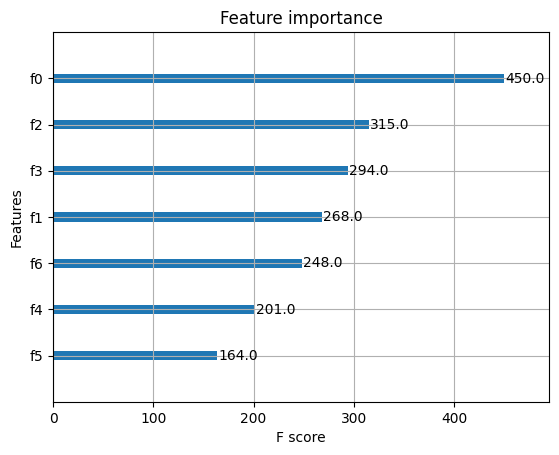

In [68]:
xgboost.plot_importance(xgb_model_)
#부하율, 온도, 습도, 최고기온, 최고습도, 조립량, 조립량 전체
#  0     1      2     3        4        5       6

In [70]:
r_sq = xgb_model_.score(xtrain, ytrain)
print(r_sq)

# xgb_model_.save_model("Use_weekly_model.txt")

r_sq = xgb_model.score(X_train, y_train)
print(r_sq)

# xgb_model.save_model("Peak_weekly_model.txt")

print(weekly_gagong_weight[100], weekly_gagong_length[100], weekly_dojang_pyomeyun[100], weekly_dojang_dojang[100], weekly_jorip_weight[100], weekly_jorip_length[100], weekly_jorip_yongchack[100], weekly_elec_use[100], weekly_elec_peak[100])

0.9933885203039234
0.9872067190319804
7306.871286029111 56245.51259818875 56009.0 148459.89250386905 10783.642996031956 58501.93874271201 5436.337415513135 3793423.2 51945.6
